# KNN

## 1. Setup and Imports

In [2]:
import os, sys

try:
    base_path = os.path.dirname(__file__)
except NameError:
    # Si __file__ n’existe pas (ex: notebook), on prend le cwd
    base_path = os.getcwd()

# Ajouter le dossier parent
sys.path.append(os.path.abspath(os.path.join(base_path, '..')))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time

# Import the environment and agents
from permuted_mnist.env.permuted_mnist import PermutedMNISTEnv
from models.KNN.knn import Agent as Knn_Agent

print("✓ Imports successful")

✓ Imports successful


We fix the seed for reproducibility:

In [4]:
seed = 42

We fix the number of CPUs:

In [5]:
n_jobs = 2

## 2. Create the Environment

Let's create an environment with 10 different permuted tasks:

In [6]:
# Create environment with 10 episodes (tasks)
env = PermutedMNISTEnv(number_episodes=10)

# Set seed for reproducibility
env.set_seed(seed)

print(f"Environment created with {env.number_episodes} permuted tasks")
print(f"Training set size: {env.train_size} samples")
print(f"Test set size: {env.test_size} samples")

Environment created with 10 permuted tasks
Training set size: 60000 samples
Test set size: 10000 samples


## 3. Understanding the Task Structure

Let's examine what a single task looks like:

In [7]:
# Get the first task
task = env.get_next_task()

print("Task structure:")
print(f"- X_train shape: {task['X_train'].shape}")
print(f"- y_train shape: {task['y_train'].shape}")
print(f"- X_test shape: {task['X_test'].shape}")
print(f"- y_test shape: {task['y_test'].shape}")
print(f"\nLabel distribution in training set:")
unique, counts = np.unique(task['y_train'], return_counts=True)
for label, count in zip(unique, counts):
    print(f"  Label {label}: {count} samples")

Task structure:
- X_train shape: (60000, 28, 28)
- y_train shape: (60000, 1)
- X_test shape: (10000, 28, 28)
- y_test shape: (10000,)

Label distribution in training set:
  Label 0: 6131 samples
  Label 1: 6742 samples
  Label 2: 5421 samples
  Label 3: 5851 samples
  Label 4: 6265 samples
  Label 5: 5958 samples
  Label 6: 5949 samples
  Label 7: 5842 samples
  Label 8: 5923 samples
  Label 9: 5918 samples


## 4. Visualize Permuted Images

Let's see how the permutation affects the images:

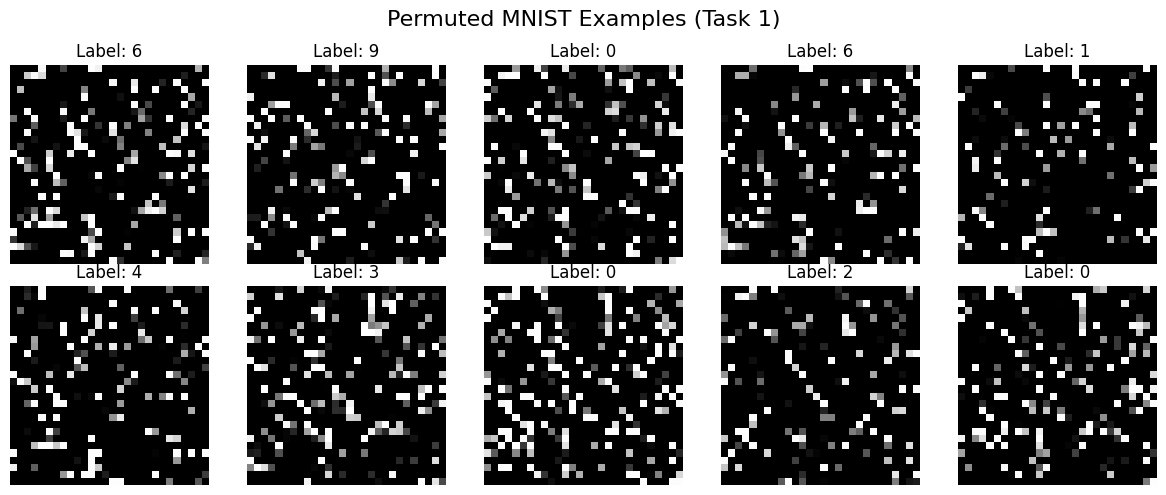

Note: The images look scrambled due to pixel permutation!
The labels are also permuted (not the original MNIST labels).


In [8]:
# Display some examples from the permuted task
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
fig.suptitle('Permuted MNIST Examples (Task 1)', fontsize=16)

for i in range(10):
    ax = axes[i // 5, i % 5]
    ax.imshow(task['X_train'][i], cmap='gray')
    ax.set_title(f'Label: {task["y_train"][i][0]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

print("Note: The images look scrambled due to pixel permutation!")
print("The labels are also permuted (not the original MNIST labels).")

## 5. Logistic regression

## 6. MLP (baseline)

## 7. KNN:

In [9]:
def knn(k, w, algo):
    # Reset environment for fresh start
    env.reset()
    env.set_seed(seed)

    # Create KNN agent
    knn_agent = Knn_Agent(k, w, algo, n_jobs)

    # Track performance
    knn_accuracies = []
    knn_times = []

    print(f"Evaluating KNN Agent with K={k}, weights={w} and algorithm={algo}:")

    # Evaluate on all tasks
    task_num = 1
    while True:
        task = env.get_next_task()
        if task is None:
            break
        if task_num >= 4: # ajout pour test rapide sur une task
            break
            
        # Reset agent for new task
        knn_agent.reset()
    
        start_time = time.time()
    
        # Train
        knn_agent.train(task['X_train'], task['y_train'])
    
        # Make predictions
        predictions = knn_agent.predict(task['X_test'])
    
        # Calculate time and accuracy
        elapsed_time = time.time() - start_time
        accuracy = env.evaluate(predictions, task['y_test'])
    
        knn_accuracies.append(accuracy)
        knn_times.append(elapsed_time)
    
        print(f"Task {task_num}: Accuracy = {accuracy:.2%}, Time = {elapsed_time:.4f}s")
        task_num += 1

    mean_accuracy = np.mean(knn_accuracies)
    std_accuracy = np.std(knn_accuracies)
    total_time = np.sum(knn_times)

    print(f"\nKNN Agent Summary:")
    print(f"  Mean accuracy: {mean_accuracy:.2%} ± {std_accuracy:.2%}")
    print(f"  Total time: {total_time:.2f}s")

    return mean_accuracy

In [10]:
Ks = [3]
weights =["distance"]
algos = ["brute"]
best_mean_accuracy = 0
best_K = None

for k in Ks:
    for w in weights:
        for algo in algos:
            mean_accuracy = knn(k, w, algo)
            print('-' * 50)
            if mean_accuracy > best_mean_accuracy:
                best_mean_accuracy = mean_accuracy
                best_k = k

print(f"The best number of neighbors is: {best_k}")
print(f"The associated mean accuracy is: {best_mean_accuracy:0.4f}")

Evaluating KNN Agent with K=3, weights=distance and algorithm=brute:
Task 1: Accuracy = 97.17%, Time = 19.6458s
Task 2: Accuracy = 97.17%, Time = 18.9201s
Task 3: Accuracy = 97.17%, Time = 18.7279s

KNN Agent Summary:
  Mean accuracy: 97.17% ± 0.00%
  Total time: 57.29s
--------------------------------------------------
The best number of neighbors is: 3
The associated mean accuracy is: 0.9717


1) best n_neighbors: 3
2) weights: Poids accordés aux voisins.
- "uniform" : tous les voisins ont le même poids (vote majoritaire).
- "distance" : les voisins les plus proches comptent davantage (vote pondéré par 1/distance).
- Ici "distance" donne une meilleur prédiction que "uniform".
3) algorithme: MNIST a 784 dimensions donc il subit le phénomène de "malédiction de la dimension". Les distances entre points deviennent presque équivalentes (le tri perd son sens car le découpage de l'espace devient extrêmement difficile), le KDTree (ou BallTree) devient quasiment aussi lent qu’une recherche exhaustive (brute), mais il garde le coût d’arbre supplémentaire en plus. 
- En résumé, en haute dimension, algorithm='kd_tree' ou 'ball_tree' devient souvent plus lent que algorithm='brute'. Ce qu"on observe ici.